# 1. DATA EXPLORATION
- Analyze the 15 power plants: production variance and missing values
- Check correlations between weather variables to identify redundancy

In [ ]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
import shap


In [ ]:
#EXPORTING DATA
train_url = "https://raw.githubusercontent.com/LeHoangViet03/Fintech-CYTech/main/Energy_Production_Train.csv"
test_url  = "https://raw.githubusercontent.com/LeHoangViet03/Fintech-CYTech/main/Energy_Production_Test.csv"

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

print(train.shape, test.shape)

#Define main columns
plant_col = "Plant_ID"
time_col = "UTC Time"
target_col = "Energy_Production"

#Parse timestamps and sort by plant and time
train[time_col] = pd.to_datetime(train[time_col])
test[time_col]  = pd.to_datetime(test[time_col])

train = train.sort_values([plant_col, time_col]).reset_index(drop=True)
test  = test.sort_values([plant_col, time_col]).reset_index(drop=True)

train.head()


(176505, 17) (59376, 17)


,UTC Time,Plant_ID,Energy_Production,Benchmark,Day-Night,Temperature descriptor,Comfort level,Visibility,Probability of precipitation for last hour,Rainfall amount for last hour,Dew point,Temperature,Wind direction,Precipitation descriptor,Sky descriptor,Humidity,Wind speed
0,2020-01-04 00:00:00+00:00,0,0.0,0.0,N,4.0,1.23,17.21,1.0,0.0,0.0,2.5,277.0,0,2.0,84.0,5.04
1,2020-01-04 01:00:00+00:00,0,0.0,0.0,N,4.0,0.28,17.39,1.0,0.0,-0.3,1.8,290.0,0,2.0,86.0,5.40
2,2020-01-04 02:00:00+00:00,0,0.0,0.0,N,4.0,-0.89,18.57,0.0,0.0,-0.7,0.9,297.0,0,2.0,89.0,5.76
3,2020-01-04 03:00:00+00:00,0,0.0,0.0,N,4.0,-1.96,19.75,0.0,0.0,-1.1,0.1,300.0,0,2.0,92.0,6.12
4,2020-01-04 04:00:00+00:00,0,0.0,0.0,N,3.0,-2.30,19.93,0.0,0.0,-1.4,-0.2,299.0,0,2.0,92.0,6.12


In [ ]:
#DATA EXPLORATION
train[plant_col].value_counts()
train.info()
display(train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176505 entries, 0 to 176504
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype              
---  ------                                      --------------   -----              
 0   UTC Time                                    176505 non-null  datetime64[ns, UTC]
 1   Plant_ID                                    176505 non-null  int64              
 2   Energy_Production                           176505 non-null  float64            
 3   Benchmark                                   176505 non-null  float64            
 4   Day-Night                                   176505 non-null  object             
 5   Temperature descriptor                      176505 non-null  float64            
 6   Comfort level                               176505 non-null  float64            
 7   Visibility                                  176505 non-null  float64            
 8   Probability of precipita

,Plant_ID,Energy_Production,Benchmark,Temperature descriptor,Comfort level,Visibility,Probability of precipitation for last hour,Rainfall amount for last hour,Dew point,Temperature,Wind direction,Precipitation descriptor,Sky descriptor,Humidity,Wind speed
count,176505.000000,176505.000000,176505.00000,176505.000000,176505.000000,176505.000000,176505.000000,176505.000000,176505.000000,176505.000000,176505.000000,1.765050e+05,176505.000000,176505.000000,176505.000000
mean,7.731056,0.009563,0.00952,6.219943,12.226085,19.013074,12.133951,0.010837,6.998382,12.731229,140.857568,-4.380011e+06,9.754715,71.130178,7.590162
std,4.562745,0.015391,0.01537,2.003239,9.615682,8.684866,18.425581,0.041445,6.926009,8.626064,112.624672,9.688588e+07,4.742879,17.316067,2.646163
min,0.000000,0.000000,0.00000,3.000000,-10.240000,0.000000,0.000000,0.000000,-13.100000,-7.600000,0.000000,-2.147484e+09,1.000000,15.000000,0.160000
25%,4.000000,0.000000,0.00000,4.000000,4.660000,14.260000,2.000000,0.000000,1.900000,6.000000,38.000000,0.000000e+00,7.000000,58.000000,5.760000
50%,8.000000,0.000000,0.00000,6.000000,10.610000,19.200000,5.000000,0.000000,6.300000,11.300000,108.000000,0.000000e+00,8.000000,75.000000,7.200000
75%,12.000000,0.015000,0.01400,8.000000,19.300000,23.480000,10.000000,0.000000,13.000000,19.300000,224.000000,0.000000e+00,15.000000,86.000000,8.640000
max,15.000000,0.071000,0.07100,12.000000,39.840000,73.850000,84.000000,0.650000,22.700000,35.600000,359.000000,4.600000e+01,18.000000,99.000000,27.000000


In [ ]:
# categorical columns
cols = ["Temperature descriptor", "Precipitation descriptor", "Sky descriptor"]

train[cols].dtypes
train[cols].isna().sum()
train[cols].nunique(dropna=False)

,0
Temperature descriptor,9
Precipitation descriptor,21
Sky descriptor,16


In [ ]:
train["Precipitation descriptor"].value_counts()

,count
Precipitation descriptor,
0,144325
2,11725
4,6701
7,3747
17,2042
5,2032
9,1837
20,1019
18,1015


In [ ]:
train["Precipitation descriptor"] = train["Precipitation descriptor"].replace(-2147483648, np.nan)
# test doesnt have mismatch

In [ ]:
#Missing value analysis
print(train.isnull().sum())
print("\n"+"="*80)
print(test.isnull().sum())
# Precipitation descriptor has 360 NAN due the outlier found in the previous cell

UTC Time                                        0
Plant_ID                                        0
Energy_Production                               0
Benchmark                                       0
Day-Night                                       0
Temperature descriptor                          0
Comfort level                                   0
Visibility                                      0
Probability of precipitation for last hour      0
Rainfall amount for last hour                   0
Dew point                                       0
Temperature                                     0
Wind direction                                  0
Precipitation descriptor                      360
Sky descriptor                                  0
Humidity                                        0
Wind speed                                      0
dtype: int64

UTC Time                                      0
Plant_ID                                      0
Energy_Production                       

In [ ]:
#Analysis of 15 power plants
plants_counts=train[plant_col].value_counts()
print(f"Number of observations per plant: {plants_counts}")

#Production statistics for each plant
production_by_plant=train.groupby("Plant_ID")["Energy_Production"].agg(["mean","std","min","max"])
display(production_by_plant)

Number of observations per plant: Plant_ID
0     11495
1     11495
3     11495
4     11495
6     11495
5     11495
7     11495
8     11495
12    11495
9     11495
10    11495
11    11495
14    11495
13    11495
15    11495
2      4080
Name: count, dtype: int64


,mean,std,min,max
Plant_ID,,,,
0,0.006816,0.011207,0.0,0.049
1,0.009457,0.014841,0.0,0.062
2,0.010683,0.015703,0.0,0.055
3,0.010838,0.016919,0.0,0.067
4,0.005186,0.008274,0.0,0.034
5,0.008600,0.013410,0.0,0.054
6,0.006253,0.009600,0.0,0.036
7,0.006058,0.009344,0.0,0.038
8,0.011513,0.017699,0.0,0.069


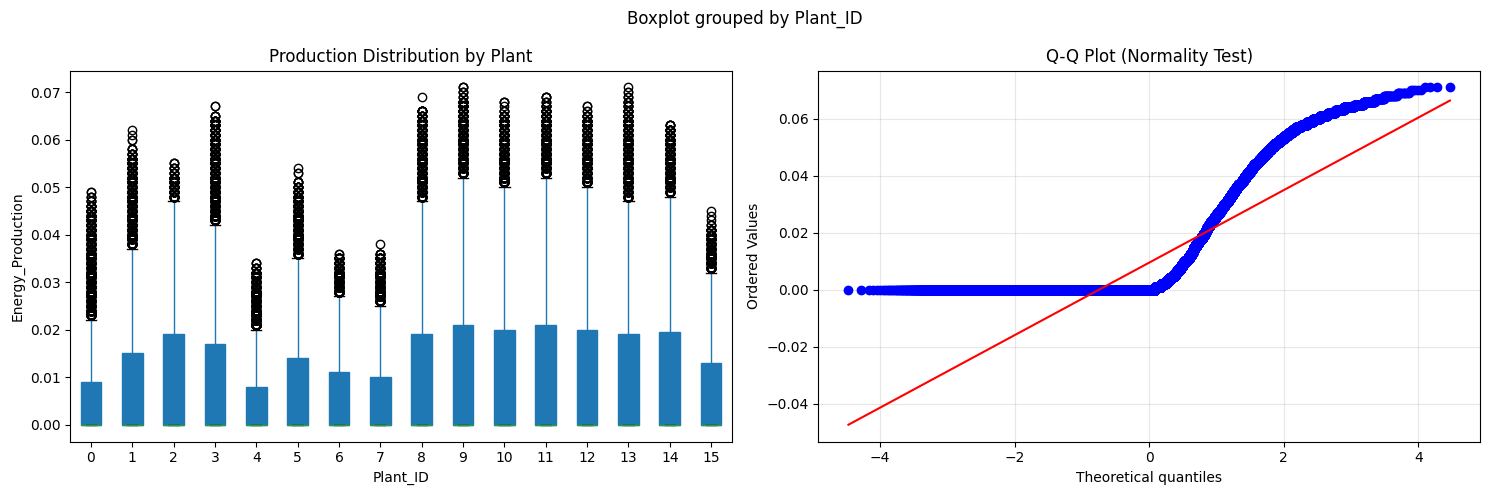


Energy_Production Statistics:
Mean: 0.01
Median: 0.00
Std: 0.02
Min: 0.00
Max: 0.07
Skewness: 1.66
Kurtosis: 1.74


In [ ]:
#Target variable (Energy production) distribution analysis
fig,axes = plt.subplots(1,2,figsize=(15,5))

#Boxplot by plant to compare distributions
train.boxplot(column="Energy_Production", by="Plant_ID", ax=axes[0],patch_artist=True, grid=False)
axes[0].set_title('Production Distribution by Plant')
axes[0].set_xlabel('Plant_ID')
axes[0].set_ylabel('Energy_Production')

#Q-Q plot to test for normality
#Reminder: points should follow the diagonal line if data is normally distributed
stats.probplot(train["Energy_Production"], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot (Normality Test)')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# key statistics
print(f"\nEnergy_Production Statistics:")
print(f"Mean: {train['Energy_Production'].mean():.2f}")
print(f"Median: {train['Energy_Production'].median():.2f}")
print(f"Std: {train['Energy_Production'].std():.2f}")
print(f"Min: {train['Energy_Production'].min():.2f}")
print(f"Max: {train['Energy_Production'].max():.2f}")
print(f"Skewness: {train['Energy_Production'].skew():.2f}")  # Measures asymmetry
print(f"Kurtosis: {train['Energy_Production'].kurtosis():.2f}")  # Measures tail heaviness

Recap for categorical variables:

*   Day-Night
*   Temperature descriptor
*   Precipitation descriptor
*   Sky descriptor


Recap for numerical variables:

* Comfort level
* Visibility
* Probability of precipitation for last hour
* Rainfall amount for last hour
* Dew point
* Temperature
* Wind direction
* Humidity
* Wind speed




Weather features identified: 9


['Comfort level',
 'Visibility',
 'Probability of precipitation for last hour',
 'Rainfall amount for last hour',
 'Dew point',
 'Temperature',
 'Wind direction',
 'Humidity',
 'Wind speed']

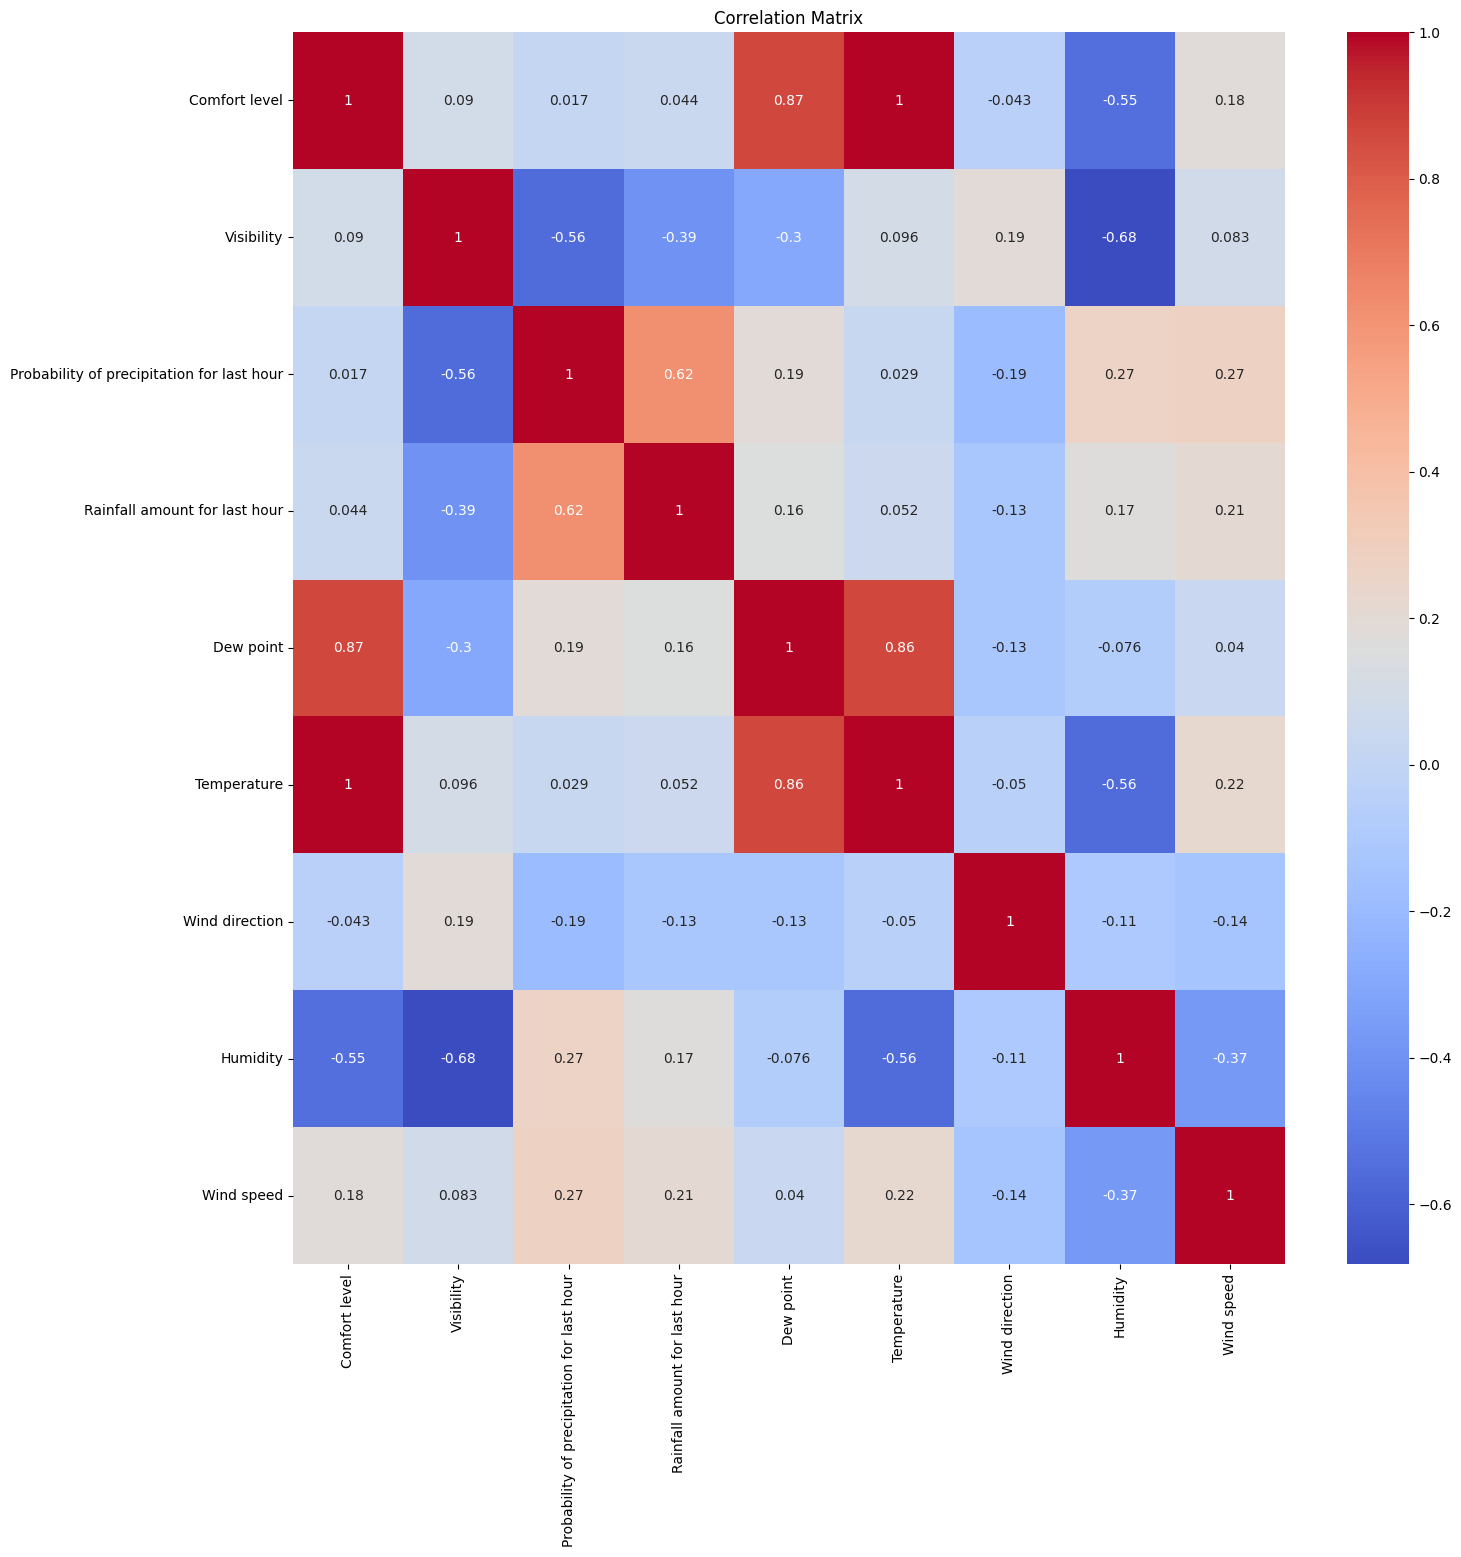

,Feature_1,Feature_2,Correlation
1,Comfort level,Temperature,0.996616
0,Comfort level,Dew point,0.867855
2,Dew point,Temperature,0.864787


In [ ]:
#Correlations between weather variables
#We computed correlations only on continuous numerical weather
#features because the descriptor variables are categorical codes
#Select only numerical weather features(excluding Plant_ID, Energy_Production and Benchmark)
weather_cols = [
    "Comfort level",
    "Visibility",
    "Probability of precipitation for last hour",
    "Rainfall amount for last hour",
    "Dew point",
    "Temperature",
    "Wind direction",
    "Humidity",
    "Wind speed"
]
print(f"Weather features identified: {len(weather_cols)}")
display(weather_cols)

#Correlation matrix
corr_matrix = train[weather_cols].corr()

#Visualisation of correlation matrix with heatmap
fig,ax=plt.subplots(figsize=(16,16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax)
ax.set_title('Correlation Matrix')
plt.show()

#Identify highly correlated feature pairs with absolute correlation >0.8 as these pairs can cause multicolinearity issue in linear models
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1,len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i,j]) > 0.8:
          high_corr_pairs.append({"Feature_1":corr_matrix.columns[i],
                                  "Feature_2":corr_matrix.columns[j],
                                  "Correlation":corr_matrix.iloc[i,j]})
display(pd.DataFrame(high_corr_pairs).sort_values("Correlation", key=lambda s: s.abs(), ascending=False).head(20))

In [ ]:
#Correlation between weather features and target
target_corr=train[weather_cols+[target_col]].corr()[target_col].drop(target_col)
target_corr=target_corr.sort_values(ascending=False)
target_corr

,Energy_Production
Temperature,0.488400
Comfort level,0.481825
Visibility,0.395889
Wind speed,0.306496
Dew point,0.187473
Wind direction,0.040365
Rainfall amount for last hour,-0.069988
Probability of precipitation for last hour,-0.115765
Humidity,-0.649811


In [ ]:
#Production Variance across plants
variance_analysis=train.groupby("Plant_ID")["Energy_Production"].agg([
    ('Mean','mean'),
    ('Std', 'std'),
    ('Variance', 'var'),
    ('CV', lambda x: x.std() / x.mean() if x.mean() != 0 else 0),  # Coefficient of Variation
    ('Min', 'min'),
    ('Max', 'max'),
    ('Range', lambda x: x.max() - x.min())
]).round(2)
display(variance_analysis)

,Mean,Std,Variance,CV,Min,Max,Range
Plant_ID,,,,,,,
0,0.01,0.01,0.0,1.64,0.0,0.05,0.05
1,0.01,0.01,0.0,1.57,0.0,0.06,0.06
2,0.01,0.02,0.0,1.47,0.0,0.06,0.06
3,0.01,0.02,0.0,1.56,0.0,0.07,0.07
4,0.01,0.01,0.0,1.60,0.0,0.03,0.03
5,0.01,0.01,0.0,1.56,0.0,0.05,0.05
6,0.01,0.01,0.0,1.54,0.0,0.04,0.04
7,0.01,0.01,0.0,1.54,0.0,0.04,0.04
8,0.01,0.02,0.0,1.54,0.0,0.07,0.07


In [ ]:
#Outlier detection

#Quartiles and IQR
Q1=train["Energy_Production"].quantile(0.25)
Q3=train["Energy_Production"].quantile(0.75)
IQR=Q3-Q1

#Outlier boundaries
lower_bound=Q1-1.5*IQR
upper_bound=Q3+1.5*IQR

#Identify outliers (value outside the boundaries)
outliers=train[(train["Energy_Production"]<lower_bound) | (train["Energy_Production"]>upper_bound)]

# Display outlier statistics
print(f"\nOutlier Statistics (IQR Method):")
print(f"Q1 (25th percentile): {Q1:.2f}")
print(f"Q3 (75th percentile): {Q3:.2f}")
print(f"IQR: {IQR:.2f}")
print(f"Lower bound: {lower_bound:.2f}")
print(f"Upper bound: {upper_bound:.2f}")
print(f"Number of outliers: {len(outliers)} ({len(outliers)/len(train)*100:.2f}%)")

#Outliers by plant
outliers_by_plant=outliers.groupby("Plant_ID").size().sort_values(ascending=False)
print("Outliers by plant:")
display(outliers_by_plant)


Outlier Statistics (IQR Method):
Q1 (25th percentile): 0.00
Q3 (75th percentile): 0.01
IQR: 0.01
Lower bound: -0.02
Upper bound: 0.04
Number of outliers: 15374 (8.71%)
Outliers by plant:


,0
Plant_ID,
9,1793
11,1775
10,1613
13,1523
8,1512
12,1502
14,1490
3,1432
1,1043


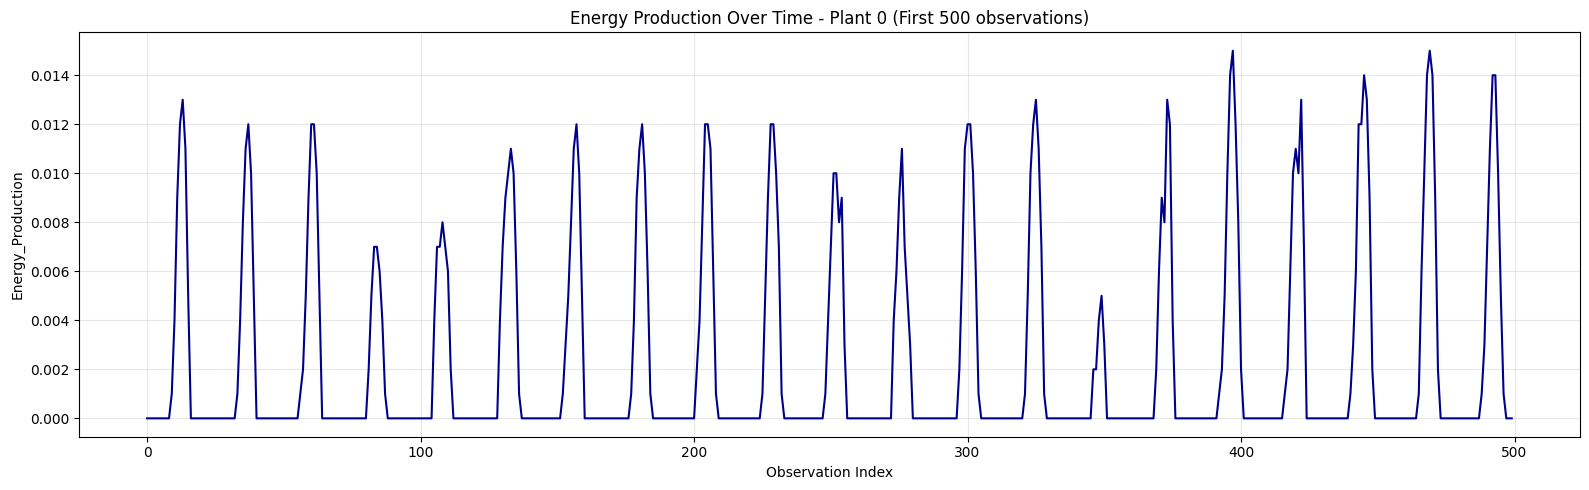

In [ ]:
#Time series analysis (to identify trend, seasonality, patterns)
sample_plant=train["Plant_ID"].unique()[0]
sample_data=train[train["Plant_ID"]==sample_plant].head(500)

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(sample_data.index, sample_data['Energy_Production'], linewidth=1.5, color='darkblue')
ax.set_title(f'Energy Production Over Time - Plant {sample_plant} (First 500 observations)')
ax.set_xlabel('Observation Index')
ax.set_ylabel('Energy_Production')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


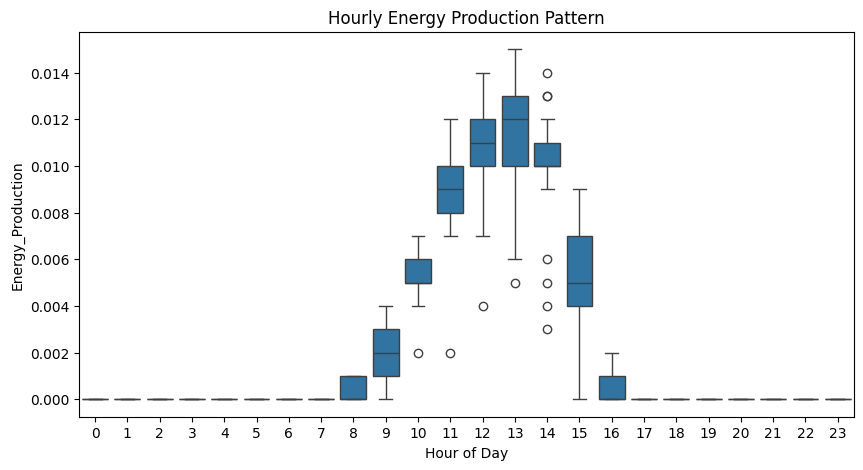

In [ ]:
sample_data = sample_data.copy()
sample_data["hour"] = sample_data[time_col].dt.hour

plt.figure(figsize=(10, 5))
sns.boxplot(x="hour", y=target_col, data=sample_data)
plt.title("Hourly Energy Production Pattern")
plt.xlabel("Hour of Day")
plt.ylabel("Energy_Production")
plt.show()



<Figure size 1000x600 with 0 Axes>

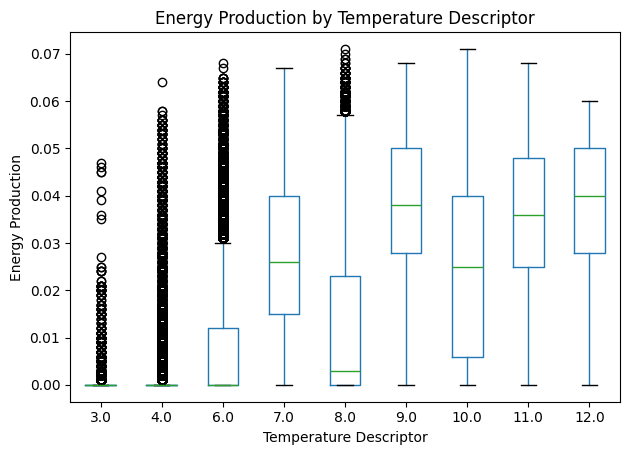

In [ ]:
# Boxplot to explore relationship between Energy Production and temperature descriptor (ordinal variable)
plt.figure(figsize=(10, 6))
train.boxplot(column=target_col, by="Temperature descriptor", grid=False)
plt.title("Energy Production by Temperature Descriptor")
plt.suptitle("")
plt.xlabel("Temperature Descriptor")
plt.ylabel("Energy Production")
plt.tight_layout()
plt.show()


# 2. FEATURE ENGINEERING

In [ ]:
# Transformation into dummy
train["Day-Night"] = (train["Day-Night"] == "D").astype(int)
test["Day-Night"]  = (test["Day-Night"]  == "D").astype(int)
# Day as 1 and Night as 0

In [ ]:
#Cyclical features
def cyclical_features(df):
  """
  Creates cyclical features for time-based.and wind direction
  Uses sin/cos to encode hour, day, month.
  """
  df=df.copy()

  df["hour"]=df[time_col].dt.hour
  df["day"]=df[time_col].dt.day
  df["month"]=df[time_col].dt.month
  df["year"]=df[time_col].dt.year
  df["day_of_week"]=df[time_col].dt.dayofweek
  df['day_of_year'] = df[time_col].dt.dayofyear

  #For hour of a day (24h)
  df['hour_sin'] = np.sin(2 * np.pi*df['hour']/24) # 24 hours cycles
  df['hour_cos'] = np.cos(2*np.pi*df['hour']/24)

  #Day of year(1-365)
  df['day_sin']=np.sin(2*np.pi*df['day_of_year']/365) # anual cycle
  df['day_cos']=np.cos(2*np.pi*df['day_of_year']/365)

  #Month of year (1-12)
  df['month_sin']=np.sin(2*np.pi*df['month']/12) # month cycle
  df['month_cos']=np.cos(2*np.pi*df['month']/12)

  #Day of week (0-6)
  df['day_of_week_sin']=np.sin(2*np.pi*df['day_of_week']/7) # weekly cycle
  df['day_of_week_cos']=np.cos(2*np.pi*df['day_of_week']/7)

  # Wind direction to 360 Dg
  df["wind_dir_sin"] = np.sin(2*np.pi*df["Wind direction"]/360)
  df["wind_dir_cos"] = np.cos(2*np.pi*df["Wind direction"]/360)


  return df

train=cyclical_features(train)
test=cyclical_features(test)


In [ ]:
#Lag and rolling features (for panel data safety)
def lag_features(df, lags=[1,2,3,24,48,168]):
  df_copy=df.copy()
  for lag in lags:
    df_copy[f'Energy_Production_lag_{lag}'] = df_copy.groupby("Plant_ID")["Energy_Production"].shift(lag)
  return df_copy
# for each plant, a production column with lag
def rolling_features(df, windows=[3,6,12,24]):
  df_copy=df.copy()

  for window in windows:
        # Rolling mean
        df_copy[f"Energy_Production_rolling_mean_{window}"] = df_copy.groupby("Plant_ID")["Energy_Production"].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).mean())

        # Rolling standard deviation
        df_copy[f"Energy_Production_rolling_std_{window}"] = df_copy.groupby("Plant_ID")["Energy_Production"].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).std().fillna(0))

        # Rolling min and max
        df_copy[f"Energy_Production_rolling_min_{window}"] = df_copy.groupby("Plant_ID")["Energy_Production"].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).min())
        df_copy[f"Energy_Production_rolling_max_{window}"] = df_copy.groupby("Plant_ID")["Energy_Production"].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).max())

  return df_copy


In [ ]:
# dummy to fix separation before concatenate
train["_is_train"] = 1
test["_is_train"]  = 0


In [ ]:
# join both datasets by order
full = pd.concat([train, test], ignore_index=True)
full = full.sort_values(["Plant_ID", time_col]).reset_index(drop=True)

# apply function
full = lag_features(full, lags=[1,2,3,24,48,168])
full = rolling_features(full, windows=[3,6,12,24])
# separation
train = full[full["_is_train"] == 1].drop(columns=["_is_train"]).reset_index(drop=True)
test  = full[full["_is_train"] == 0].drop(columns=["_is_train"]).reset_index(drop=True)
new_features=[col for col in train.columns if col not in ["Plant_ID","UTC Time", "Energy_Production", 'Day-Night']+weather_cols]
print(f"New features created:{len(new_features)}")


New features created:42


In [ ]:
# fill lags nan (with median only in train)
lag_roll_cols = [c for c in train.columns if ("_lag_" in c) or ("_rolling_" in c)]
med = train[lag_roll_cols].median()
train[lag_roll_cols] = train[lag_roll_cols].fillna(med)
test[lag_roll_cols]  = test[lag_roll_cols].fillna(med)

Recap new features until here:


**To each plant:**
*   Energy_Production_lag_1,2,3,24...

**Rolling features-energy production-**
*   Window 3,6,12,24

**Time features**
*   hour sin-cos/day/month/dayweek/


**Wind direction**







In [ ]:
train["Plant_ID_raw"] = train["Plant_ID"]
test["Plant_ID_raw"]  = test["Plant_ID"]

In [ ]:
# ONE HOT Encoding for our categorical variables
cat_cols = ["Plant_ID", "Precipitation descriptor", "Sky descriptor"]

train = pd.get_dummies(train, columns=cat_cols, dummy_na=True)
test  = pd.get_dummies(test,  columns=cat_cols, dummy_na=True)

X_cols = [c for c in train.columns if c not in ["Energy_Production","Benchmark","UTC Time","Plant_ID_raw"]]
test = test.reindex(columns=X_cols + ["Benchmark","UTC Time","Plant_ID_raw"], fill_value=0)


In [ ]:
list(train.columns)

['UTC Time',
 'Energy_Production',
 'Benchmark',
 'Day-Night',
 'Temperature descriptor',
 'Comfort level',
 'Visibility',
 'Probability of precipitation for last hour',
 'Rainfall amount for last hour',
 'Dew point',
 'Temperature',
 'Wind direction',
 'Humidity',
 'Wind speed',
 'hour',
 'day',
 'month',
 'year',
 'day_of_week',
 'day_of_year',
 'hour_sin',
 'hour_cos',
 'day_sin',
 'day_cos',
 'month_sin',
 'month_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'wind_dir_sin',
 'wind_dir_cos',
 'Energy_Production_lag_1',
 'Energy_Production_lag_2',
 'Energy_Production_lag_3',
 'Energy_Production_lag_24',
 'Energy_Production_lag_48',
 'Energy_Production_lag_168',
 'Energy_Production_rolling_mean_3',
 'Energy_Production_rolling_std_3',
 'Energy_Production_rolling_min_3',
 'Energy_Production_rolling_max_3',
 'Energy_Production_rolling_mean_6',
 'Energy_Production_rolling_std_6',
 'Energy_Production_rolling_min_6',
 'Energy_Production_rolling_max_6',
 'Energy_Production_rolling_mean_12',

In [ ]:
[c for c in test.columns if "Energy_Production_lag_" in c][:5], test[[c for c in test.columns if "Energy_Production_lag_" in c][:1]].head()


(['Energy_Production_lag_1',
  'Energy_Production_lag_2',
  'Energy_Production_lag_3',
  'Energy_Production_lag_24',
  'Energy_Production_lag_48'],
    Energy_Production_lag_1
 0                    0.000
 1                    0.004
 2                    0.004
 3                    0.004
 4                    0.004)

In [ ]:
train[["Plant_ID_nan","Precipitation descriptor_nan","Sky descriptor_nan"]].sum()
train = train.drop(columns=["Plant_ID_nan", "Sky descriptor_nan"])
test  = test.drop(columns=["Plant_ID_nan",  "Sky descriptor_nan"])


In [ ]:
# Split 30%-70% With time
def panel_time_split(df, plant_col, time_col,val_ratio=0.3):
  df=df.sort_values([plant_col,time_col]).copy()
  train_parts,val_parts=[],[]
  for pid, sub in df.groupby(plant_col):
    cut=int(len(sub)*(1-val_ratio))
    train_parts.append(sub.iloc[:cut])
    val_parts.append(sub.iloc[cut:])
  return pd.concat(train_parts), pd.concat(val_parts)

train_df,val_df=panel_time_split(train,"Plant_ID_raw", time_col,0.3)
X_train_orig = train_df.drop(columns=[target_col, "Benchmark", time_col]) #features (X) in train_df
y_train = train_df[target_col] #target (y) in train_df

X_val_orig = val_df.drop(columns=[target_col, "Benchmark", time_col])#features (X) in val_df.
y_val = val_df[target_col] # target in val_df

In [ ]:
# # Split 30%-70% With time
# val_ratio = 0.30

# df = train.sort_values(time_col).reset_index(drop=True)
# cut = int(len(df) * (1 - val_ratio))

# train_df = df.iloc[:cut].copy() # oldest 70%
# val_df   = df.iloc[cut:].copy() # recent 30%

# X_train_orig = train_df.drop(columns=[target_col, "Benchmark", time_col]) #features (X) in train_df
# y_train = train_df[target_col] #target (y) in train_df

# X_val_orig = val_df.drop(columns=[target_col, "Benchmark", time_col])#features (X) in val_df.
# y_val = val_df[target_col] # target in val_df

In [ ]:
#Dimensionality reduction (PCA)
weather_features = [c for c in weather_cols if c in X_train_orig.columns and c != "Wind direction"]
weather_features
print(f"Number of original weather features for PCA: {len(weather_features)}")

#Add transformed wind direction into weather features
for c in ["wind_dir_sin","wind_dir_cos"]:
  if c in X_train_orig.columns:
    weather_features.append(c)

Number of original weather features for PCA: 8


In [ ]:
#Standardize the features
scaler = StandardScaler()
#It standardizes the weather features in the training set
Xtr_w = scaler.fit_transform(X_train_orig[weather_features])

# Fit PCA with all components to analyze variance
pca_full = PCA()
pca_full.fit(Xtr_w)
# Explained variance ratio

explained = pca_full.explained_variance_ratio_
cumulative = np.cumsum(explained)
print("Explained Variance by Component:")
for i, (var, cum) in enumerate(zip(explained, cumulative)):
    print(f"  PC{i+1}: {var:.4f} ({var*100:.2f}%) | Cumulative: {cum:.4f} ({cum*100:.2f}%)")

Explained Variance by Component:
  PC1: 0.3320 (33.20%) | Cumulative: 0.3320 (33.20%)
  PC2: 0.2627 (26.27%) | Cumulative: 0.5947 (59.47%)
  PC3: 0.1334 (13.34%) | Cumulative: 0.7281 (72.81%)
  PC4: 0.1112 (11.12%) | Cumulative: 0.8393 (83.93%)
  PC5: 0.0657 (6.57%) | Cumulative: 0.9050 (90.50%)
  PC6: 0.0497 (4.97%) | Cumulative: 0.9546 (95.46%)
  PC7: 0.0288 (2.88%) | Cumulative: 0.9835 (98.35%)
  PC8: 0.0157 (1.57%) | Cumulative: 0.9991 (99.91%)
  PC9: 0.0006 (0.06%) | Cumulative: 0.9998 (99.98%)
  PC10: 0.0002 (0.02%) | Cumulative: 1.0000 (100.00%)


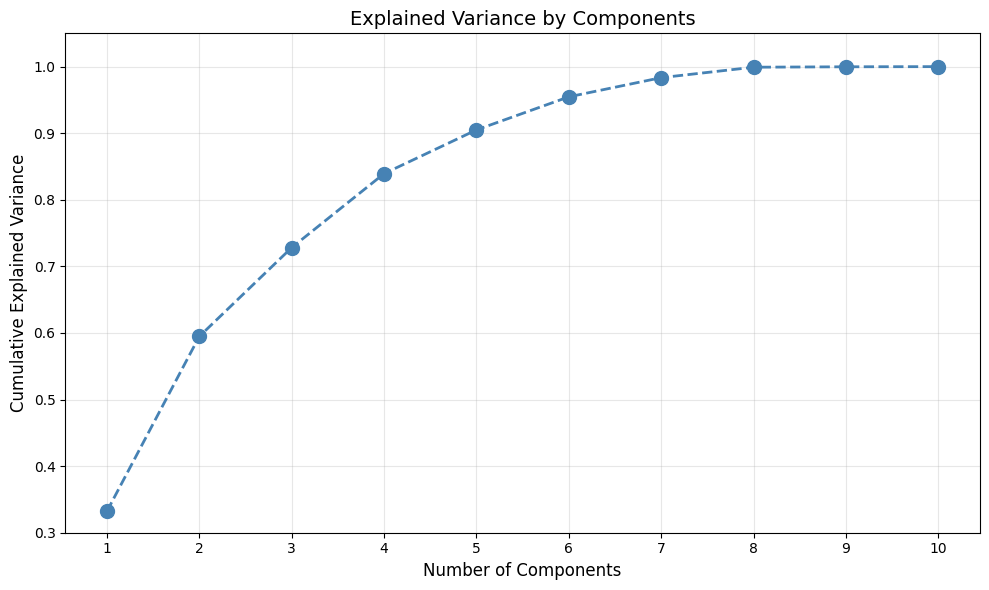


Components needed for 90% variance: 5
Components needed for 95% variance: 6


In [ ]:
# Plot Explained Variance by Components
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative)+1), cumulative, 'o--',
         color='steelblue', linewidth=2, markersize=10)
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.title('Explained Variance by Components', fontsize=14)
plt.xticks(range(1, len(cumulative)+1))
plt.ylim(0.3, 1.05)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find number of components for 90% and 95% variance
n_components_95 = np.argmax(cumulative >= 0.95) + 1
n_components_90 = np.argmax(cumulative >= 0.90) + 1
print(f"\nComponents needed for 90% variance: {n_components_90}")
print(f"Components needed for 95% variance: {n_components_95}")

In [ ]:
# define k
k = n_components_95
k

np.int64(6)

In [ ]:
# Create the pca components
Xval_w = scaler.transform(X_val_orig[weather_features])
Xtest_w = scaler.transform(test[weather_features])

pca = PCA(n_components=k, random_state=42)
Xtr_pc = pca.fit_transform(Xtr_w)
Xval_pc = pca.transform(Xval_w)
Xtest_pc = pca.transform(Xtest_w)

pc_cols = [f"PCA_{i+1}" for i in range(k)]

In [ ]:
# final datasets considering the pca elements created
other_cols = [c for c in X_train_orig.columns if c not in weather_features]

X_train_pca = pd.concat([X_train_orig[other_cols].reset_index(drop=True),
                         pd.DataFrame(Xtr_pc, columns=pc_cols)], axis=1)

X_val_pca = pd.concat([X_val_orig[other_cols].reset_index(drop=True),
                       pd.DataFrame(Xval_pc, columns=pc_cols)], axis=1)

test_with_pca = pd.concat([test[other_cols].reset_index(drop=True),
                           pd.DataFrame(Xtest_pc, columns=pc_cols)], axis=1)

X_train_orig.shape, X_train_pca.shape, X_val_orig.shape, X_val_pca.shape


((123546, 103), (123546, 99), (52959, 103), (52959, 99))

In [ ]:
#train_scaled = scaler.fit_transform(train[weather_features])
#test_scaled  = scaler.transform(test[weather_features])

#pca = PCA(n_components=n_components)

#train_pca = pca.fit_transform(train_scaled)
#test_pca  = pca.transform(test_scaled)

#train_pca_df = pd.DataFrame(train_pca,
                            #columns=[f"PCA_{i+1}" for i in range(train_pca.shape[1])],
                            #index=train.index)

#test_pca_df = pd.DataFrame(test_pca,
                          # columns=[f"PCA_{i+1}" for i in range(test_pca.shape[1])],
                           #index=test.index)

#non_weather_features = [c for c in train.columns if c not in weather_features + [target_col, "Benchmark", time_col]]

#train_with_pca = pd.concat([train[non_weather_features], train_pca_df], axis=1)
#test_with_pca  = pd.concat([test[non_weather_features],  test_pca_df],  axis=1)

In [ ]:
'''val_ratio = 0.30

def panel_time_split(df, plant_col, time_col, target_col, val_ratio=0.30):
    df = df.sort_values([plant_col, time_col]).copy()
    train_parts, val_parts = [], []
    for pid, g in df.groupby(plant_col, sort=False):
        cut = int((1 - val_ratio) * len(g))
        train_parts.append(g.iloc[:cut])
        val_parts.append(g.iloc[cut:])
    train_df = pd.concat(train_parts).sort_values([plant_col, time_col]).reset_index(drop=True)
    val_df   = pd.concat(val_parts).sort_values([plant_col, time_col]).reset_index(drop=True)
    return (train_df.drop(columns=[target_col]),
            train_df[target_col],
            val_df.drop(columns=[target_col]),
            val_df[target_col])'''


'val_ratio = 0.30\n\ndef panel_time_split(df, plant_col, time_col, target_col, val_ratio=0.30):\n    df = df.sort_values([plant_col, time_col]).copy()\n    train_parts, val_parts = [], []\n    for pid, g in df.groupby(plant_col, sort=False):\n        cut = int((1 - val_ratio) * len(g))\n        train_parts.append(g.iloc[:cut])\n        val_parts.append(g.iloc[cut:])\n    train_df = pd.concat(train_parts).sort_values([plant_col, time_col]).reset_index(drop=True)\n    val_df   = pd.concat(val_parts).sort_values([plant_col, time_col]).reset_index(drop=True)\n    return (train_df.drop(columns=[target_col]),\n            train_df[target_col],\n            val_df.drop(columns=[target_col]),\n            val_df[target_col])'

In [ ]:
'''#time series split
#val_size=0.3
def time_series_split(df):
  df=df.sort_index()

  n_splits=int(len(df)*(1-0.3))

  train_df=df.iloc[:n_splits].copy()
  val_df=df.iloc[n_splits:].copy()

  train_features=train_df.drop(columns=["Energy_Production"])
  train_target=train_df["Energy_Production"]

  val_features=val_df.drop(columns=["Energy_Production"])
  val_target=val_df["Energy_Production"]

  return train_features, train_target, val_features, val_target

X_train_orig,y_train_orig,X_val_orig,y_val_orig=time_series_split(pd.concat([train[original_features],train[target_col]],axis=1))
X_train_pca,y_train_pca,X_val_pca,y_val_pca=time_series_split(pd.concat([train_with_pca,train[target_col]],axis=1))

print(f"Training set shape: {X_train_orig.shape}")
print(f"Validation set shape: {X_val_orig.shape}")'''

'#time series split\n#val_size=0.3\ndef time_series_split(df):\n  df=df.sort_index()\n\n  n_splits=int(len(df)*(1-0.3))\n\n  train_df=df.iloc[:n_splits].copy()\n  val_df=df.iloc[n_splits:].copy()\n\n  train_features=train_df.drop(columns=["Energy_Production"])\n  train_target=train_df["Energy_Production"]\n\n  val_features=val_df.drop(columns=["Energy_Production"])\n  val_target=val_df["Energy_Production"]\n\n  return train_features, train_target, val_features, val_target\n\nX_train_orig,y_train_orig,X_val_orig,y_val_orig=time_series_split(pd.concat([train[original_features],train[target_col]],axis=1))\nX_train_pca,y_train_pca,X_val_pca,y_val_pca=time_series_split(pd.concat([train_with_pca,train[target_col]],axis=1))\n\nprint(f"Training set shape: {X_train_orig.shape}")\nprint(f"Validation set shape: {X_val_orig.shape}")'

RECAP VARIABLES

** val_df: 30% of each plant and is used to creat the x_val_orig and x_val_pca and y_val
**features**
*   X_train_orig.shape: Training set original model
*   X_train_pca: training set model PCA
*   X_val_orig: Validation set original model
*   X_val_pca: validation set PCA
* X_test_ orig:  feature set for your test data, using the original features before pca
* x_test_pca: feature set for test data using pca transformation

**energy production target**
*   y_train: target in training set
*  y_val : target in validation set
* y_test: actyal energy production target values for test set(used to evalute final performance of choosen model on unseen data)








# Model Selection & Tuning:

In [ ]:
from sklearn.base import clone

SCALE_MODELS={"Ridge","Lasso","KNN"}
def train_and_evaluate(X_train, y_train, X_val, y_val, models_dict,scale_models=SCALE_MODELS):
    results = {}

    #fit scaler for specific models
    scaler=StandardScaler()
    X_train_scaled=scaler.fit_transform(X_train)
    X_val_scaled=scaler.transform(X_val)


    for model_name, model in models_dict.items():
        m=clone(model)

        if model_name in scale_models:
          Xtr_use,Xva_use=X_train_scaled,X_val_scaled
        else:
          Xtr_use,Xva_use=X_train,X_val

        m.fit(Xtr_use, y_train)

        train_preds = np.clip(m.predict(Xtr_use), 0, None)
        val_preds   = np.clip(m.predict(Xva_use),   0, None)

        results[model_name] = {
            "Train_RMSE": np.sqrt(mean_squared_error(y_train,train_preds)),
            "Val_RMSE": np.sqrt(mean_squared_error(y_val,val_preds)),
            "Train_R2": r2_score(y_train,train_preds),
            "Val_R2": r2_score(y_val,val_preds),
            "Val_Preds": val_preds,
            "Model": m
        }
    return results

In [ ]:
#Models to train
models = {
    'Ridge': Ridge(alpha=1, random_state=42),
    'Lasso': Lasso(alpha=0.1,max_iter=5000,random_state=42),
    'KNN': KNeighborsRegressor(n_neighbors=25),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    #"AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42, algorithm='SAMME'),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
}

results_orig = train_and_evaluate(X_train_orig, y_train, X_val_orig, y_val, models)
results_pca  = train_and_evaluate(X_train_pca,  y_train, X_val_pca,  y_val, models)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:23:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:33:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
#results to df for a clean comparison table
def results_to_df(results, feature_set):
  rows=[]

  for name, d in results.items():
    rows.append({
        "Model":name,
        "Features":feature_set,
        "Train_RMSE":d["Train_RMSE"],
        "Val_RMSE":d["Val_RMSE"],
        "Train_R2":d["Train_R2"],
        "Val_R2":d['Val_R2']
    })
  return pd.DataFrame(rows)

res_df=results_to_df(results_orig, "Original")
res_pca_df=results_to_df(results_pca, "PCA")
scores=pd.concat([res_df,res_pca_df]).sort_values("Val_RMSE")


In [ ]:
scores

,Model,Features,Train_RMSE,Val_RMSE,Train_R2,Val_R2
6,LightGBM,PCA,0.002219,0.002903,0.981158,0.951069
6,LightGBM,Original,0.002204,0.002912,0.981418,0.950753
3,RandomForest,Original,0.000685,0.002981,0.998203,0.948414
4,GradientBoosting,Original,0.003119,0.002990,0.962788,0.948103
3,RandomForest,PCA,0.000690,0.002994,0.998178,0.947969
4,GradientBoosting,PCA,0.003115,0.003015,0.962883,0.947207
5,XGBoost,PCA,0.001516,0.003055,0.991204,0.945799
5,XGBoost,Original,0.001548,0.003137,0.990827,0.942858
0,Ridge,PCA,0.003515,0.003181,0.952736,0.941269
0,Ridge,Original,0.003514,0.003184,0.952752,0.941158


RESULTS: LightGBM good and
pca didnt improve

# local models


In [ ]:
#Function to apply light model to each plant
def train_evaluate_lgbm_local(X_train, y_train, X_val, y_val):
    """
    Trains and evaluates a LightGBM model for a single plant.
    Returns validation RMSE and R2 scores.
    """
    model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    val_preds = model.predict(X_val)
    val_preds = np.clip(val_preds, 0, None) # Ensure non-negative predictions

    rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    r2 = r2_score(y_val, val_preds)
    return rmse, r2



In [ ]:
# create a list to store local results (one model per plant)
local_model_results = []

# get the unique plant ids from the raw plant id column
unique_plant_ids = sorted(X_train_orig["Plant_ID_raw"].dropna().unique())

# drop the id columns because in a local model we already know the plant
# (so Plant_ID_raw and Plant_ID_* one-hot columns add no useful information)
plant_id_cols_to_drop = ["Plant_ID_raw"] + [c for c in X_train_orig.columns if c.startswith("Plant_ID_")]


# loop over each plant and train a separate model
for plant_id in unique_plant_ids:

    # filter train set for this plant
    X_train_plant = X_train_orig[X_train_orig["Plant_ID_raw"] == plant_id].copy()
    y_train_plant = y_train[X_train_orig["Plant_ID_raw"] == plant_id].copy()

    # filter validation set for this plant
    X_val_plant = X_val_orig[X_val_orig["Plant_ID_raw"] == plant_id].copy()
    y_val_plant = y_val[X_val_orig["Plant_ID_raw"] == plant_id].copy()

    # drop Plant_ID-related columns from both sets
    X_train_plant_filtered = X_train_plant.drop(columns=plant_id_cols_to_drop, errors="ignore")
    X_val_plant_filtered   = X_val_plant.drop(columns=plant_id_cols_to_drop, errors="ignore")

    # align validation columns to training columns (avoid column mismatch errors)
    X_val_plant_filtered = X_val_plant_filtered.reindex(columns=X_train_plant_filtered.columns, fill_value=0)

    # train + evaluate the local LightGBM model for this plant
    rmse, r2 = train_evaluate_lgbm_local(
        X_train_plant_filtered, y_train_plant,
        X_val_plant_filtered,   y_val_plant
    )

    # store results
    local_model_results.append({
        "Plant_ID": plant_id,
        "Val_RMSE": rmse,
        "Val_R2": r2,
        "n_val": len(y_val_plant)
    })


local_results_df = pd.DataFrame(local_model_results).sort_values("Val_RMSE")
display(local_results_df)


,Plant_ID,Val_RMSE,Val_R2,n_val
4,4,0.001548,0.945498,3449
7,7,0.001687,0.948481,3449
6,6,0.001780,0.947849,3449
15,15,0.002312,0.943800,3449
0,0,0.002372,0.941492,3449
5,5,0.002531,0.948159,3449
1,1,0.002836,0.943911,3449
3,3,0.003022,0.940905,3449
8,8,0.003256,0.950425,3449
12,12,0.003348,0.946608,3449


In [ ]:
# benchmark RMSE continue from here

In [ ]:
bench_preds = val_df["Benchmark"].values
# errors
rmse_bench = np.sqrt(mean_squared_error(y_val, bench_preds))
r2_bench   = r2_score(y_val, bench_preds)
